In [1]:
from collections import OrderedDict

import pandas as pd
import numpy as np
import seaborn as sns
sns.set()

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

### Workflow:

1. Problem setup and baselining
2. Feature engineering to improve our model
3. Preliminary results

In [2]:
path = 'data/archive (2)/'
df_train = pd.read_csv(path+'train.csv')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67463 entries, 0 to 67462
Data columns (total 35 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            67463 non-null  int64  
 1   Loan Amount                   67463 non-null  int64  
 2   Funded Amount                 67463 non-null  int64  
 3   Funded Amount Investor        67463 non-null  float64
 4   Term                          67463 non-null  int64  
 5   Batch Enrolled                67463 non-null  object 
 6   Interest Rate                 67463 non-null  float64
 7   Grade                         67463 non-null  object 
 8   Sub Grade                     67463 non-null  object 
 9   Employment Duration           67463 non-null  object 
 10  Home Ownership                67463 non-null  float64
 11  Verification Status           67463 non-null  object 
 12  Payment Plan                  67463 non-null  object 
 13  L

In [3]:
#df_test_X = pd.read_csv(path+'test.csv')
#df_test_y = pd.read_csv(path+'submission.csv') (not good data set)

### Create Pair Plot

In [4]:
def get_pairplot_cols(df, first_col, last_col):
    sns.set_style("whitegrid", {'axes.grid' : False})
    #plt.figure()
    cols_to_plot = df.columns[first_col:last_col-1].tolist() + ['Loan Status'] # explicitly add the column "top_listing" to your list of columns to plot
    sns.pairplot(df[cols_to_plot], hue ='Loan Status')

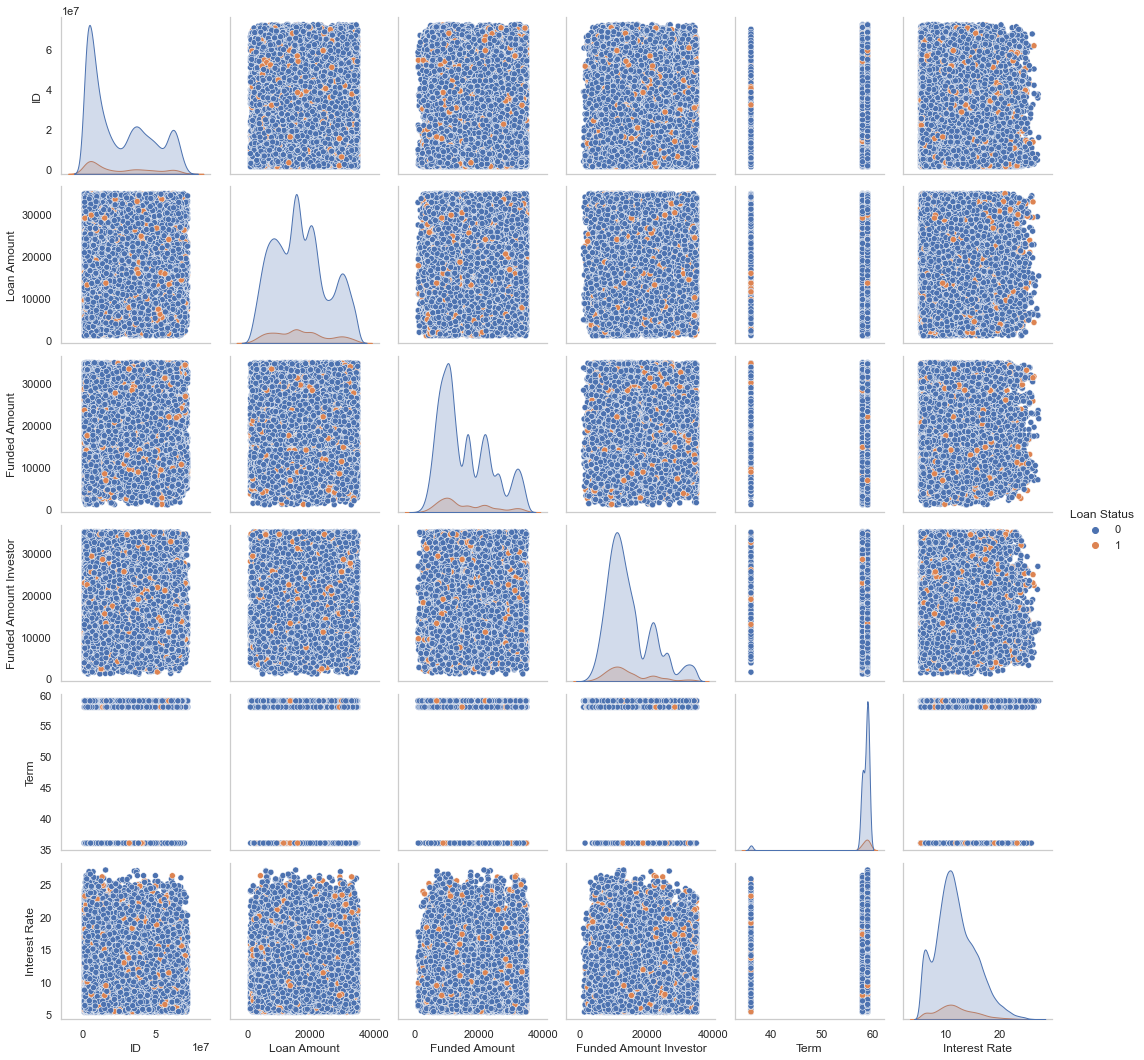

In [5]:
get_pairplot_cols(df_train,0,10)

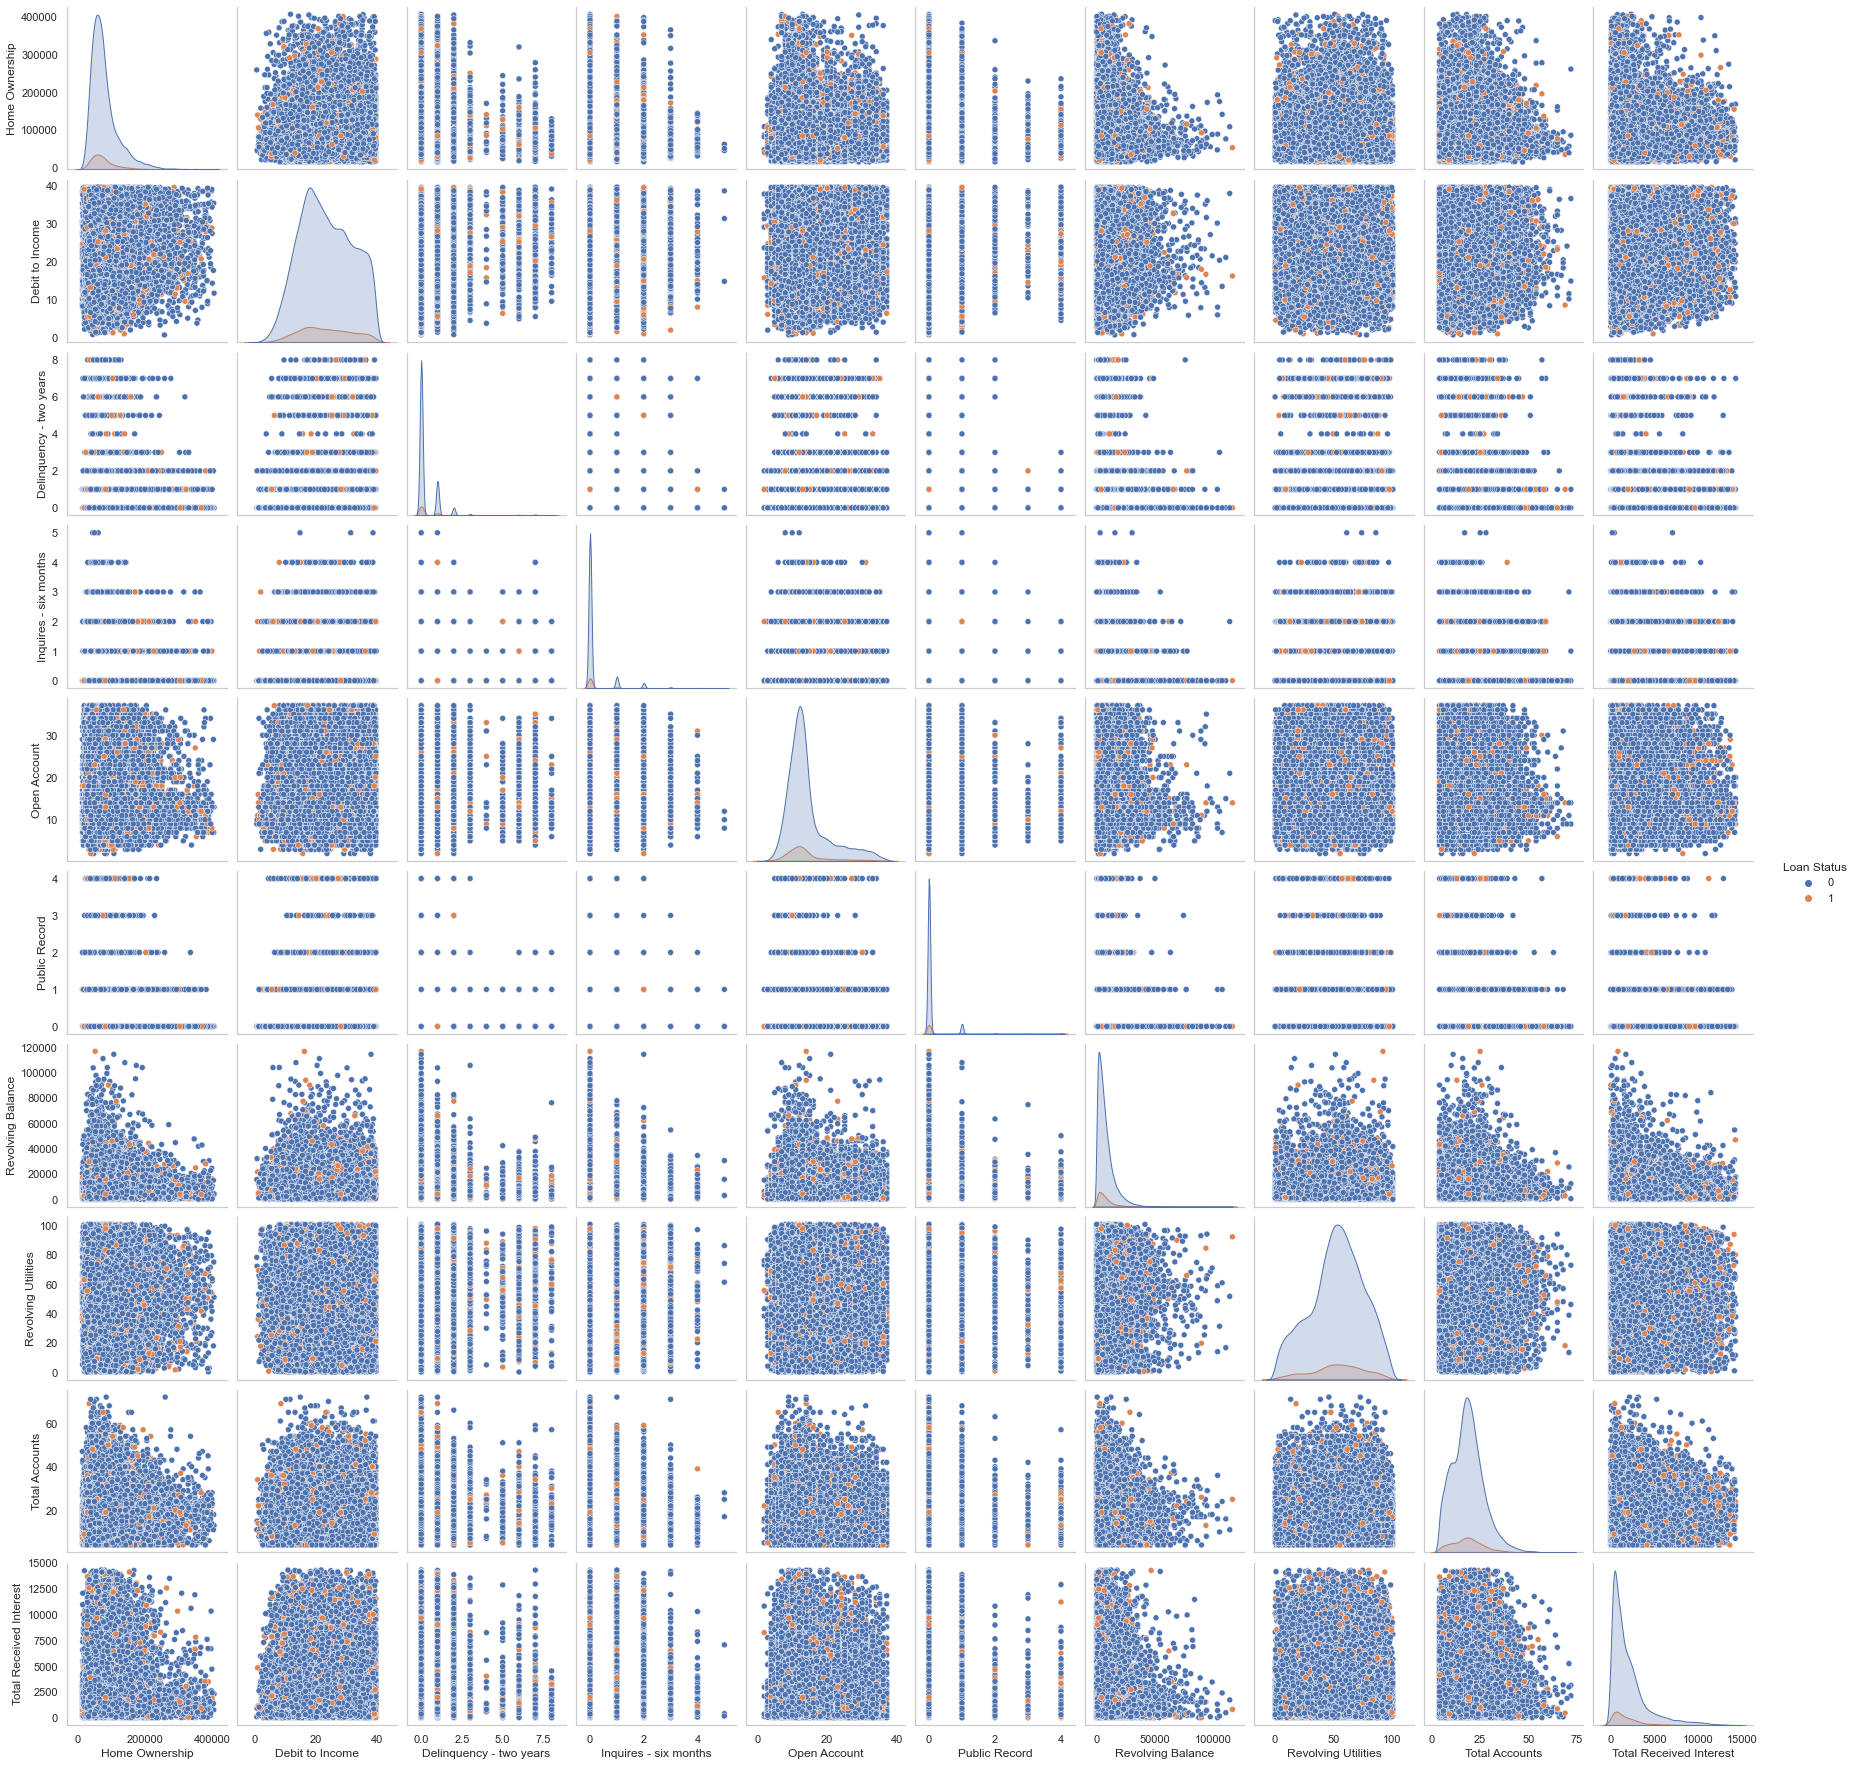

In [6]:
get_pairplot_cols(df_train,10,25)

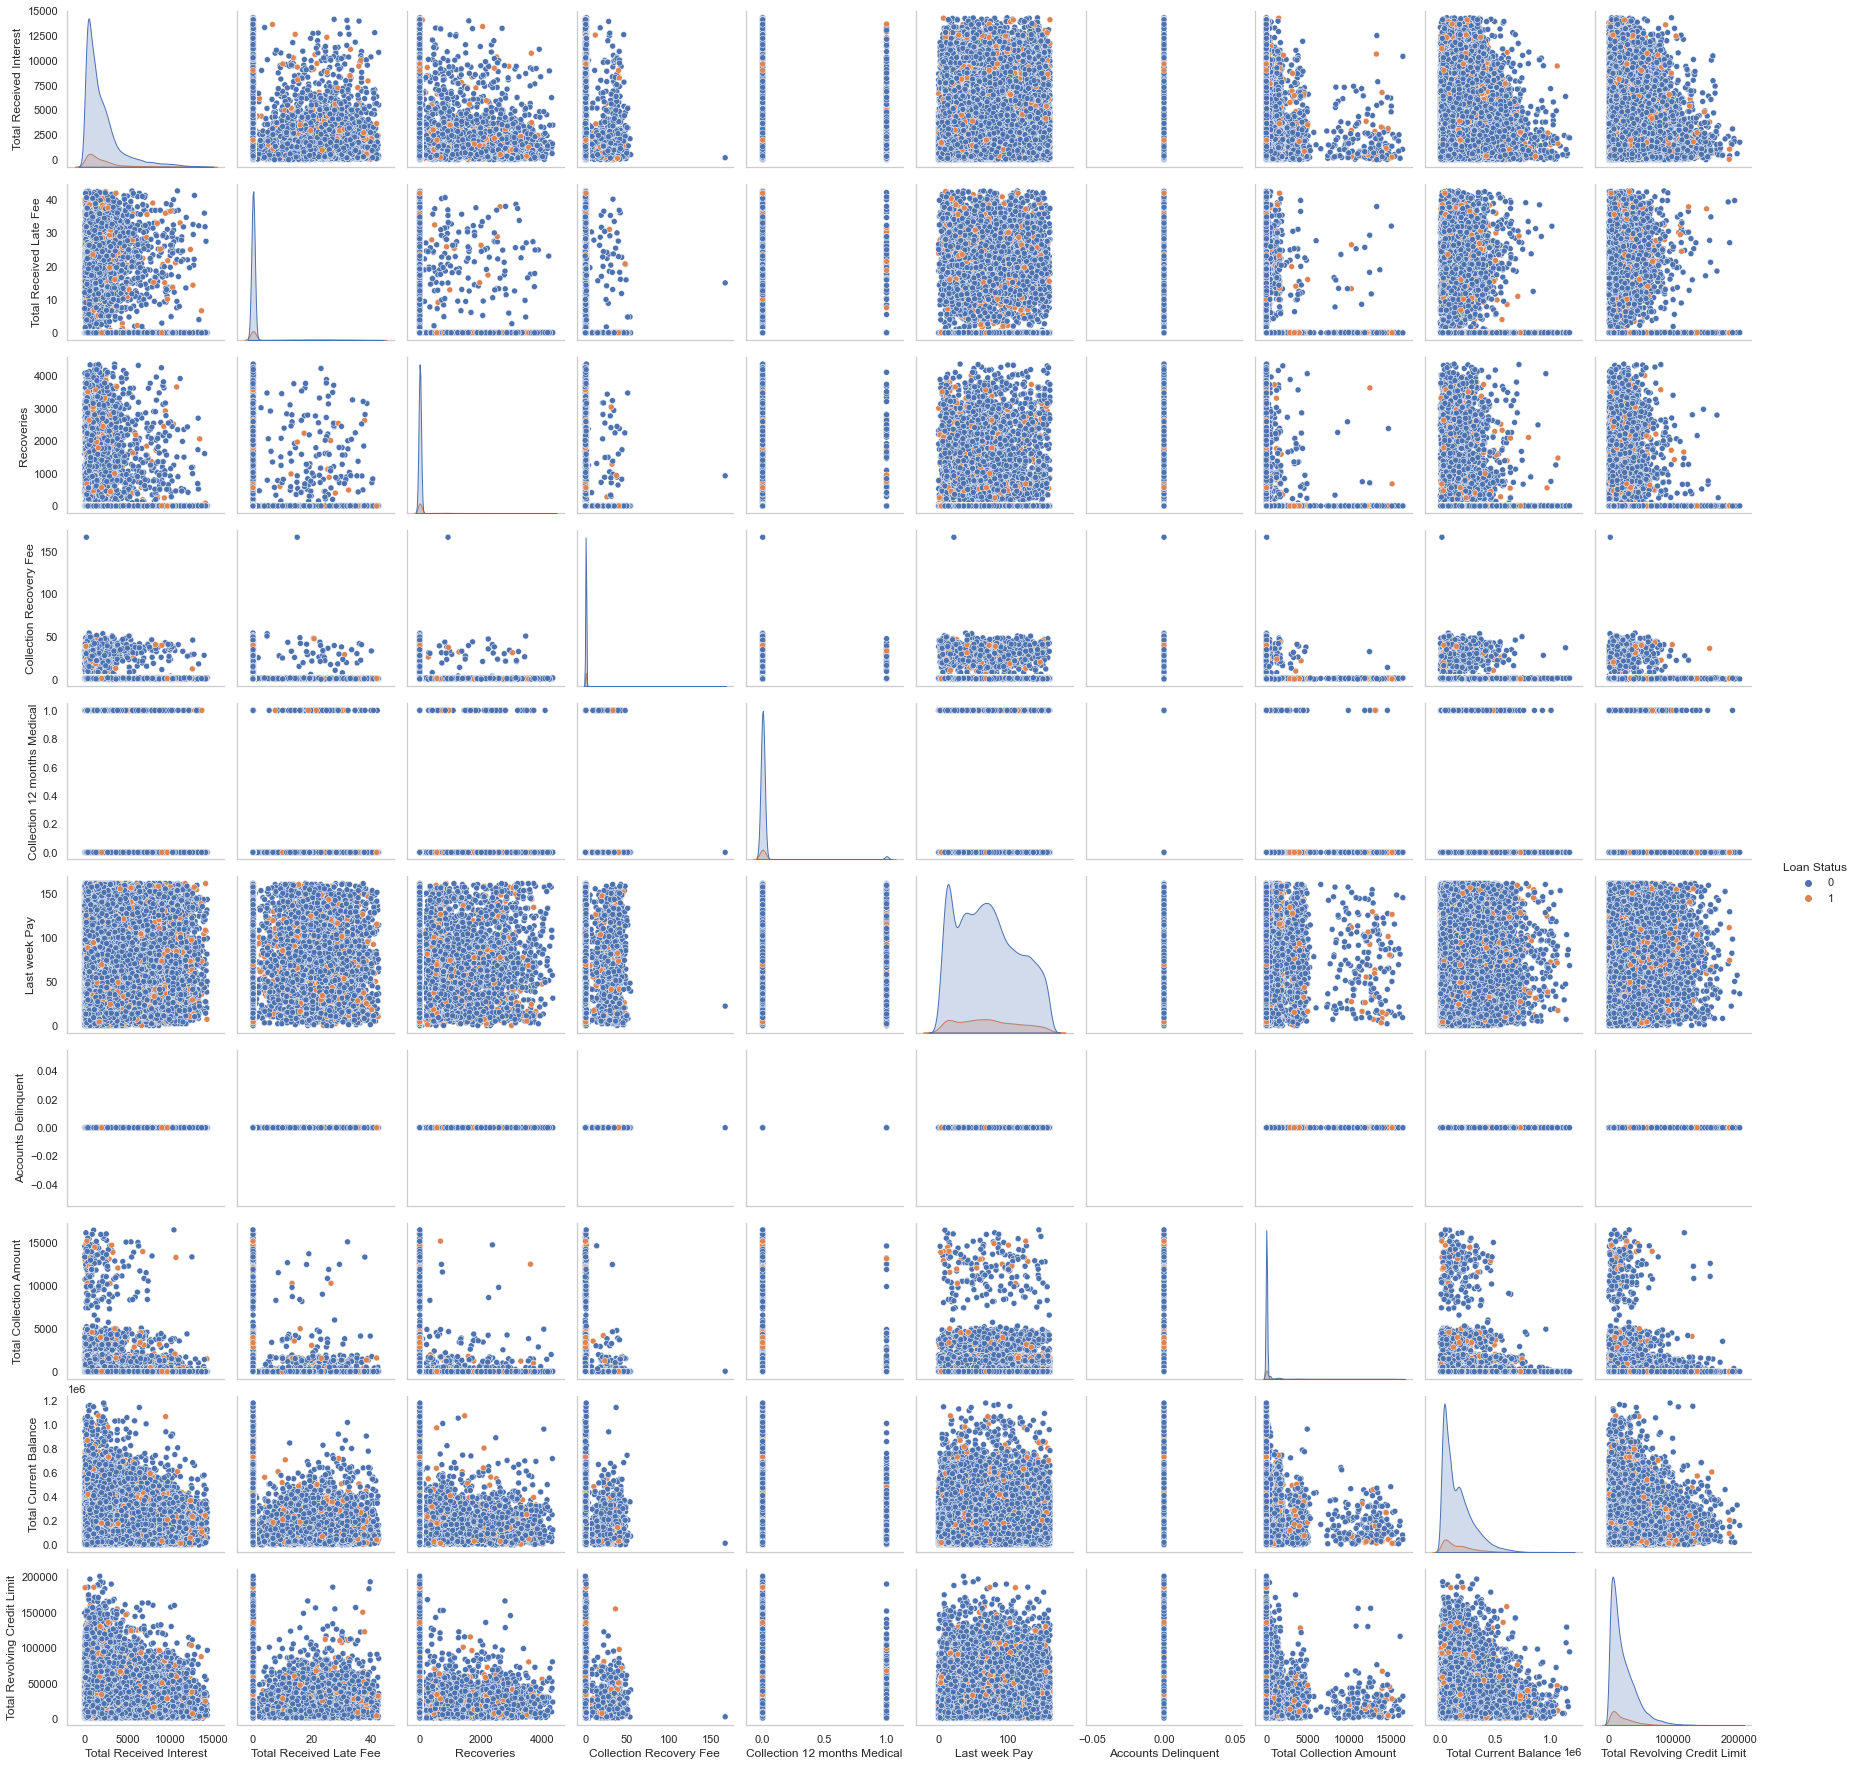

In [7]:
get_pairplot_cols(df_train,22,35)

<AxesSubplot:>

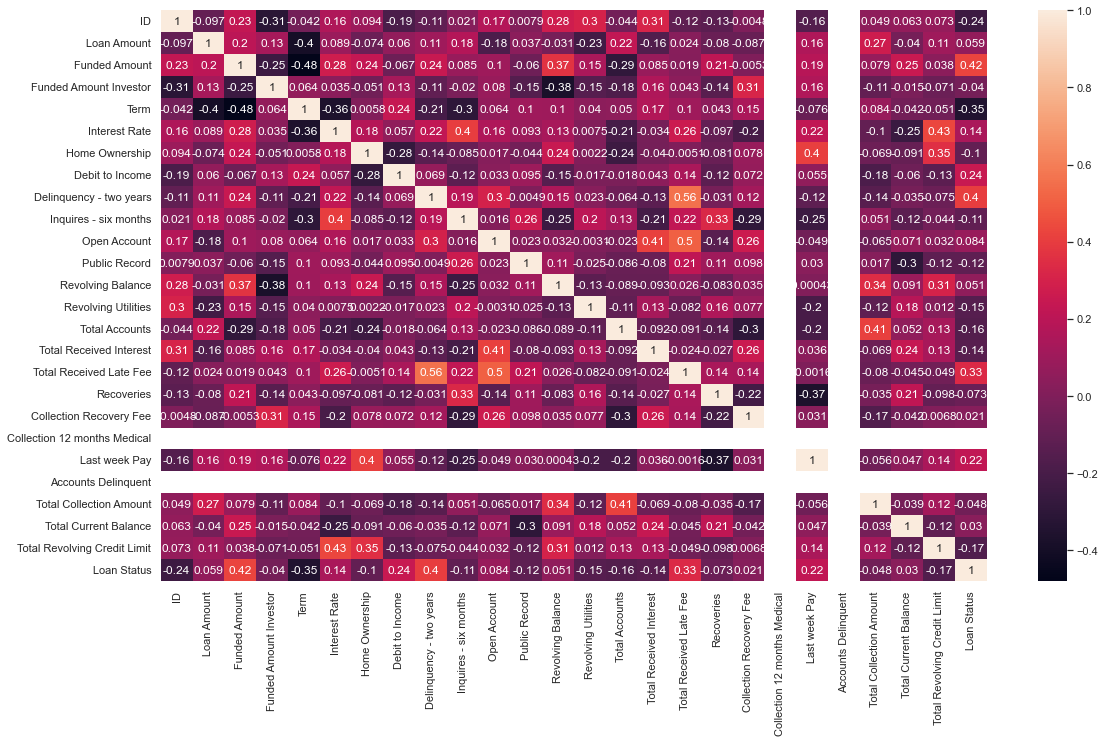

In [8]:
import matplotlib.pyplot as plt
df_forheatmap = df_train.select_dtypes(exclude=['object'])
df_forheatmap.head()
#sns.heatmap(df_forheatmap, vmin=0, vmax=1)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
sns.heatmap(df_forheatmap.iloc[0:35,:].corr(), annot=True)
#df_forheatmap.info()

### Prelim Feature Selection

In [3]:
df_new = df_train.drop(['Collection 12 months Medical','Accounts Delinquent','Term','Batch Enrolled','Sub Grade','Payment Plan',\
              'Initial List Status','Application Type','Recoveries','Revolving Balance','Loan Title'],axis=1)
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67463 entries, 0 to 67462
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            67463 non-null  int64  
 1   Loan Amount                   67463 non-null  int64  
 2   Funded Amount                 67463 non-null  int64  
 3   Funded Amount Investor        67463 non-null  float64
 4   Interest Rate                 67463 non-null  float64
 5   Grade                         67463 non-null  object 
 6   Employment Duration           67463 non-null  object 
 7   Home Ownership                67463 non-null  float64
 8   Verification Status           67463 non-null  object 
 9   Debit to Income               67463 non-null  float64
 10  Delinquency - two years       67463 non-null  int64  
 11  Inquires - six months         67463 non-null  int64  
 12  Open Account                  67463 non-null  int64  
 13  P

### 1. Check if it is an imbalanced classification task

In [4]:
target_pcts = df_new['Loan Status'].value_counts(normalize = True)
print(target_pcts)

0    0.90749
1    0.09251
Name: Loan Status, dtype: float64


<AxesSubplot:>

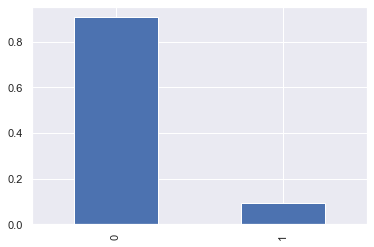

In [5]:
target_pcts.plot(kind = 'bar')

In [6]:
#sns.pairplot(df_train[])

In [7]:
def get_user_split_data(df, test_size=.2, seed=42):

    rs = np.random.RandomState(seed)
    
    total_users = df['ID'].unique() 
    test_users = rs.choice(total_users, 
                           size=int(total_users.shape[0] * test_size), 
                           replace=False)

    df_tr = df[~df['ID'].isin(test_users)]
    df_te = df[df['ID'].isin(test_users)] 

    y_tr, y_te = df_tr['Loan Status'], df_te['Loan Status']
    X_tr = df_tr.drop(['ID','Loan Status'],axis=1)
    X_te = df_te.drop(['ID','Loan Status'],axis=1)

    return X_tr, X_te, y_tr, y_te

In [8]:

The_X = pd.get_dummies(df_new.drop(['Loan Status'],axis=1),drop_first=True)
#The_X = df_train[['ID','Debit to Income','Public Record','Total Accounts','Total Current Balance']]
The_X['Loan Status'] = df_new[['Loan Status']]

In [9]:
X = The_X.drop(['Loan Status'],axis = 1)
y = df_train[['Loan Status']]
X_tr_x, X_te_o, y_tr, y_te = get_user_split_data(The_X)
from sklearn.model_selection import train_test_split
#Split data into 3: 60% train, 20% validation, 20% test
X_tr_o, X_val_o, y_tr, y_val = train_test_split(X_tr_x, y_tr, test_size=0.25, random_state=2019)


#### Scale Data

In [10]:
scaler = StandardScaler()

In [11]:
X_tr = pd.DataFrame(scaler.fit_transform(X_tr_o),columns = X_tr_o.columns)
X_te = pd.DataFrame(scaler.fit_transform(X_te_o),columns = X_te_o.columns)
X_val = pd.DataFrame(scaler.fit_transform(X_val_o),columns = X_val_o.columns)

In [12]:
X_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40478 entries, 0 to 40477
Data columns (total 29 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Loan Amount                          40478 non-null  float64
 1   Funded Amount                        40478 non-null  float64
 2   Funded Amount Investor               40478 non-null  float64
 3   Interest Rate                        40478 non-null  float64
 4   Home Ownership                       40478 non-null  float64
 5   Debit to Income                      40478 non-null  float64
 6   Delinquency - two years              40478 non-null  float64
 7   Inquires - six months                40478 non-null  float64
 8   Open Account                         40478 non-null  float64
 9   Public Record                        40478 non-null  float64
 10  Revolving Utilities                  40478 non-null  float64
 11  Total Accounts              

In [13]:
X_te.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13492 entries, 0 to 13491
Data columns (total 29 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Loan Amount                          13492 non-null  float64
 1   Funded Amount                        13492 non-null  float64
 2   Funded Amount Investor               13492 non-null  float64
 3   Interest Rate                        13492 non-null  float64
 4   Home Ownership                       13492 non-null  float64
 5   Debit to Income                      13492 non-null  float64
 6   Delinquency - two years              13492 non-null  float64
 7   Inquires - six months                13492 non-null  float64
 8   Open Account                         13492 non-null  float64
 9   Public Record                        13492 non-null  float64
 10  Revolving Utilities                  13492 non-null  float64
 11  Total Accounts              

In [14]:
X_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13493 entries, 0 to 13492
Data columns (total 29 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Loan Amount                          13493 non-null  float64
 1   Funded Amount                        13493 non-null  float64
 2   Funded Amount Investor               13493 non-null  float64
 3   Interest Rate                        13493 non-null  float64
 4   Home Ownership                       13493 non-null  float64
 5   Debit to Income                      13493 non-null  float64
 6   Delinquency - two years              13493 non-null  float64
 7   Inquires - six months                13493 non-null  float64
 8   Open Account                         13493 non-null  float64
 9   Public Record                        13493 non-null  float64
 10  Revolving Utilities                  13493 non-null  float64
 11  Total Accounts              

In [15]:
print(X_te.columns.tolist())

['Loan Amount', 'Funded Amount', 'Funded Amount Investor', 'Interest Rate', 'Home Ownership', 'Debit to Income', 'Delinquency - two years', 'Inquires - six months', 'Open Account', 'Public Record', 'Revolving Utilities', 'Total Accounts', 'Total Received Interest', 'Total Received Late Fee', 'Collection Recovery Fee', 'Last week Pay', 'Total Collection Amount', 'Total Current Balance', 'Total Revolving Credit Limit', 'Grade_B', 'Grade_C', 'Grade_D', 'Grade_E', 'Grade_F', 'Grade_G', 'Employment Duration_OWN', 'Employment Duration_RENT', 'Verification Status_Source Verified', 'Verification Status_Verified']


In [16]:
full_model = X_te.columns.tolist()

#### Oversampling

In [32]:
import imblearn.over_sampling
from sklearn.metrics import f1_score, roc_auc_score
# setup for the ratio argument of RandomOverSampler initialization
n_pos = np.sum(y_tr == 1)
n_neg = np.sum(y_tr == 0)
ratio = {1 : n_pos * 5, 0 : n_neg} 

# randomly oversample positive samples: create 4x as many 
ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=42) 
    
X_tr_rs, y_tr_rs = ROS.fit_resample(X_tr, y_tr)

lr = LogisticRegression(solver='liblinear') 
lr.fit(X_tr, y_tr)

print('Simple Logistic Regression; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_te, lr.predict(X_te)), roc_auc_score(y_te, lr.predict_proba(X_te)[:,1]))) 

lr_os = LogisticRegression(solver='liblinear') 
lr_os.fit(X_tr_rs, y_tr_rs)

print('Logistic Regression on Oversampled Train Data; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_te, lr_os.predict(X_te)), roc_auc_score(y_te, lr_os.predict_proba(X_te)[:,1])))


Simple Logistic Regression; Test F1: 0.000, Test AUC: 0.510
Logistic Regression on Oversampled Train Data; Test F1: 0.002, Test AUC: 0.511


#### SMOTE

In [33]:
smt = imblearn.over_sampling.SMOTE(sampling_strategy = ratio, random_state = 42)
X_tr_smt, y_tr_smt = smt.fit_resample(X_tr,y_tr)
lr_smote = LogisticRegression(solver='liblinear')
lr_smote.fit(X_tr_smt, y_tr_smt)
print('Logistic Regression on SMOTE Train Data; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_te, lr_smote.predict(X_te)), roc_auc_score(y_te, lr_smote.predict_proba(X_te)[:,1])))

Logistic Regression on SMOTE Train Data; Test F1: 0.000, Test AUC: 0.499


### Cross-Validation with KNN

#### smt

In [347]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
# Train on training set, and Test on testing set
knn = KNeighborsClassifier(n_neighbors=12)
knn.fit(X_tr_smt, y_tr_smt)
y_pred = knn.predict(X_te)
print(metrics.accuracy_score(y_te, y_pred))
print('KNN on SMOTE Train Data; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_te, knn.predict(X_te)), roc_auc_score(y_te, knn.predict_proba(X_te)[:,1])))
print('KNN on SMT Train Data; PRECISION: %.3f, RECALL: %.3f' % \
      (precision_score(y_te, knn.predict(X_te)), recall_score(y_te, knn.predict(X_te))))

0.700118588793359
KNN on SMOTE Train Data; Test F1: 0.136, Test AUC: 0.512
KNN on SMT Train Data; PRECISION: 0.092, RECALL: 0.261


In [106]:
from sklearn.model_selection import cross_val_score
# 10-fold cross-validation with K=5 for KNN (the n_neighbors parameter)
knn = KNeighborsClassifier(n_neighbors=12)
scores = cross_val_score(knn, X_tr_smt, y_tr_smt, cv=10, scoring='accuracy')
print(scores)
print(scores.mean())

[0.70562771 0.71771284 0.79635642 0.79365079 0.79758254 0.80028865
 0.79884539 0.80155151 0.7872993  0.7966805 ]
0.7795595643557036


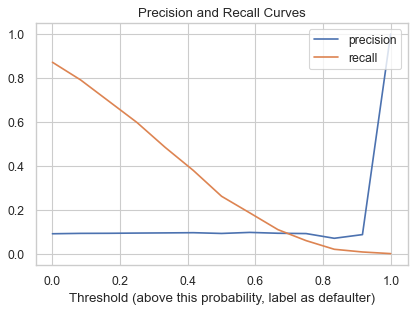

In [108]:
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
knn.fit(X_tr_smt, y_tr_smt)
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_te, knn.predict_proba(X_te)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='upper right')
plt.xlabel('Threshold (above this probability, label as defaulter)');
#plt.xlim([0,1]);
plt.title('Precision and Recall Curves');

Text(89.00000000000007, 0.5, 'actual')

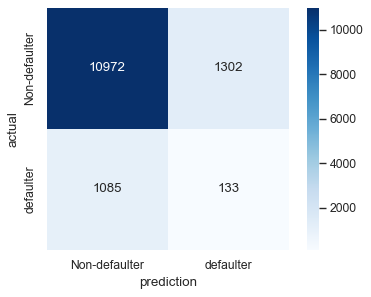

In [348]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
knn.fit(X_tr_smt, y_tr_smt)
y_predict = (knn.predict_proba(X_te)[:, 1] >= 0.69)
fraud_confusion = confusion_matrix(y_te, y_predict)
plt.figure(dpi=80)
sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
       xticklabels=['Non-defaulter', 'defaulter'],
       yticklabels=['Non-defaulter', 'defaulter']);
plt.xlabel('prediction')
plt.ylabel('actual')

### os

In [349]:
knn.fit(X_tr_rs, y_tr_rs)
y_pred = knn.predict(X_te)
print(metrics.accuracy_score(y_te, y_pred))
print('KNN on Oversampling Train Data; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_te, knn.predict(X_te)), roc_auc_score(y_te, knn.predict_proba(X_te)[:,1])))
print('KNN on OS Train Data; PRECISION: %.3f, RECALL: %.3f' % \
      (precision_score(y_te, knn.predict(X_te)), recall_score(y_te, knn.predict(X_te))))

0.7660094871034687
KNN on Oversampling Train Data; Test F1: 0.121, Test AUC: 0.502
KNN on OS Train Data; PRECISION: 0.092, RECALL: 0.179


In [113]:
knn = KNeighborsClassifier(n_neighbors=12)
scores = cross_val_score(knn, X_tr_rs, y_tr_rs, cv=10, scoring='accuracy')
print(scores)
print(scores.mean())

[0.69949495 0.69877345 0.71626984 0.71031746 0.70521378 0.70575501
 0.71243009 0.71784232 0.70755908 0.71585784]
0.7089513827223551


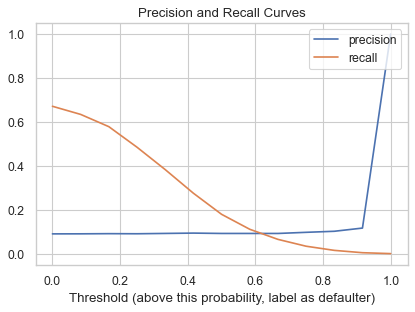

In [114]:
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
knn.fit(X_tr_rs, y_tr_rs)
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_te, knn.predict_proba(X_te)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='upper right')
plt.xlabel('Threshold (above this probability, label as defaulter)');
#plt.xlim([0,1]);
plt.title('Precision and Recall Curves');

Text(89.00000000000007, 0.5, 'actual')

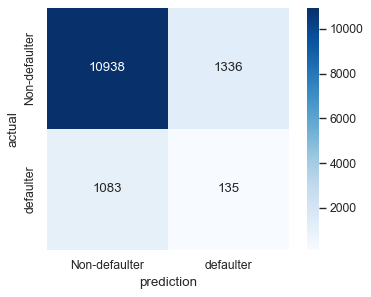

In [115]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
knn.fit(X_tr_rs, y_tr_rs)
y_predict = (knn.predict_proba(X_te)[:, 1] >= 0.62)
fraud_confusion = confusion_matrix(y_te, y_predict)
plt.figure(dpi=80)
sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
       xticklabels=['Non-defaulter', 'defaulter'],
       yticklabels=['Non-defaulter', 'defaulter']);
plt.xlabel('prediction')
plt.ylabel('actual')

In [26]:
# search for an optimal value of K for KNN
#k_range = list(range(1, 25))
#k_scores = []
#for k in k_range:
#    knn = KNeighborsClassifier(n_neighbors=k)
#    scores = cross_val_score(knn, X, np.ravel(y), cv=10, scoring='accuracy')
#    k_scores.append(scores.mean())
#print(k_scores)

In [27]:
#import matplotlib.pyplot as plt
#%matplotlib inline

# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
#plt.plot(k_range, k_scores)
#plt.xlabel('Value of K for KNN')
#plt.ylabel('Cross-Validated Accuracy')

In [28]:
#thres = 0.35
#def make_confusion_matrix(model, threshold=thres):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
 #   y_predict = (model.predict_proba(X_te)[:, 1] >= threshold)
  #  fraud_confusion = confusion_matrix(y_te, y_predict)
   # plt.figure(dpi=80)
    #sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
     #      xticklabels=['Non-defaulter', 'defaulter'],
      #     yticklabels=['Non-defaulter', 'defaulter']);
    #plt.xlabel('prediction')
    #plt.ylabel('actual')

#### Find the best K prameter for KNN

In [36]:
from sklearn.model_selection import GridSearchCV
# define the parameter values that should be searched
k_range = list(range(1, 25))
weight_options = ['uniform', 'distance']
# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(n_neighbors=k_range, weights=weight_options)
print(param_grid)
# instantiate and fit the grid
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
grid.fit(X_te, y_te)
# examine the best model -- still 13 neighbors and uniform weights
print("Best params: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)
print("Best score: ", grid.best_score_)

{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24], 'weights': ['uniform', 'distance']}
Best params:  {'n_neighbors': 12, 'weights': 'uniform'}
Best estimator:  KNeighborsClassifier(n_neighbors=12)
Best score:  0.9097242950882685


Text(89.00000000000007, 0.5, 'actual')

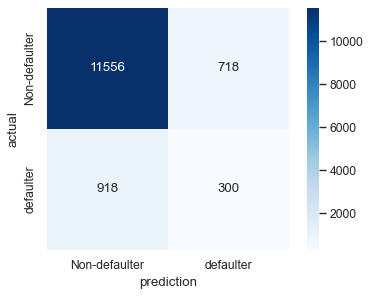

In [150]:
y_predict_g = (grid.predict_proba(X_te)[:, 1] >= 0.19)
fraud_confusion = confusion_matrix(y_te, y_predict_g)
plt.figure(dpi=80)
sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
       xticklabels=['Non-defaulter', 'defaulter'],
       yticklabels=['Non-defaulter', 'defaulter']);
plt.xlabel('prediction')
plt.ylabel('actual')

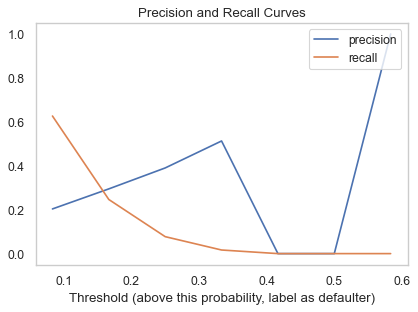

In [151]:
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_te, grid.predict_proba(X_te)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='upper right')
plt.xlabel('Threshold (above this probability, label as defaulter)');
#plt.xlim([0,1]);
plt.title('Precision and Recall Curves');

ROC AUC score =  0.773320785951213


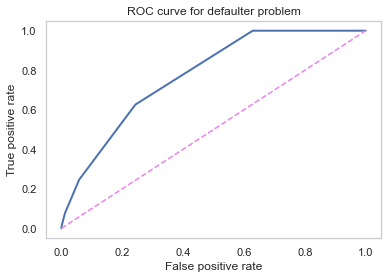

In [42]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(y_te, grid.predict_proba(X_te)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for defaulter problem');
print("ROC AUC score = ", roc_auc_score(y_te, grid.predict_proba(X_te)[:,1]))

### Logistic Regression - Soft prediction

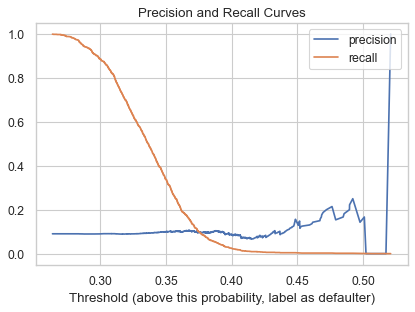

In [116]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_te, lr_os.predict_proba(X_te)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='upper right')
plt.xlabel('Threshold (above this probability, label as defaulter)');
#plt.xlim([0,1]);
plt.title('Precision and Recall Curves');

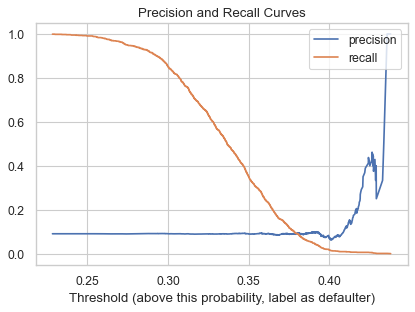

In [117]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_te, lr_smote.predict_proba(X_te)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='upper right')
plt.xlabel('Threshold (above this probability, label as defaulter)');
#plt.xlim([0,1]);
plt.title('Precision and Recall Curves');

In [118]:
thres = 0.37
y_pred = (lr.predict_proba(X_te)[:,1]>thres)
print('Simple Logistic Regression; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_te, y_pred), roc_auc_score(y_te, lr.predict_proba(X_te)[:,1]))) 

y_predos = (lr_os.predict_proba(X_te)[:,1]>0.37)
print('Logistic Regression on Oversampled Train Data; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_te, y_predos), roc_auc_score(y_te, lr_os.predict_proba(X_te)[:,1])))

y_predoss = (lr_smote.predict_proba(X_te)[:,1]>0.375)
print('Logistic Regression on Oversampled Train Data; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_te, y_predoss), roc_auc_score(y_te, lr_smote.predict_proba(X_te)[:,1])))

Simple Logistic Regression; Test F1: 0.000, Test AUC: 0.510
Logistic Regression on Oversampled Train Data; Test F1: 0.115, Test AUC: 0.511
Logistic Regression on Oversampled Train Data; Test F1: 0.102, Test AUC: 0.499


#### Perform Cross-validation

In [119]:
scoress = cross_val_score(lr_smote, X_tr_smt, y_tr_smt, cv=10, scoring='accuracy')
print(scoress)
print(scoress.mean())

[0.66269841 0.66269841 0.66269841 0.66269841 0.66281797 0.66281797
 0.66281797 0.66281797 0.66281797 0.66263756]
0.6627521054726538


In [120]:
scoress = cross_val_score(lr_os, X_tr_rs, y_tr_rs, cv=10, scoring='accuracy')
print(scoress)
print(scoress.mean())

[0.66269841 0.66215729 0.66197691 0.66233766 0.66245715 0.66263756
 0.66263756 0.66227675 0.66245715 0.66263756]
0.6624274008610107


#### Confusion Matrix

In [121]:
def make_confusion_matrix(model, threshold=thres):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_te)[:, 1] >= threshold)
    fraud_confusion = confusion_matrix(y_te, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['Non-defaulter', 'defaulter'],
           yticklabels=['Non-defaulter', 'defaulter']);
    plt.xlabel('prediction')
    plt.ylabel('actual')

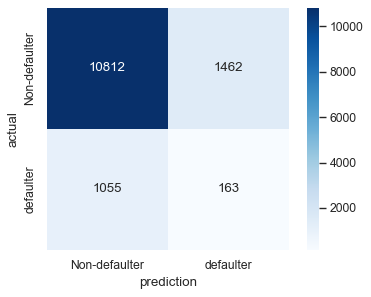

In [122]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
make_confusion_matrix(lr_os)

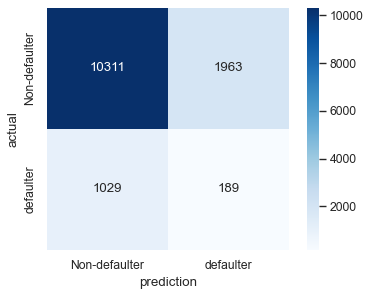

In [123]:
make_confusion_matrix(lr_smote)

In [124]:
from sklearn.metrics import balanced_accuracy_score


#### Plot ROC using data (SMOTE)

In [125]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt


### Random Forest, Deciscion Tree

In [126]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import balanced_accuracy_score

In [127]:
tree_param = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}

dt = DecisionTreeClassifier()
dt_grid = GridSearchCV(dt, tree_param, cv = 10)
# Fit the random search model
dt_grid.fit(X_tr_rs, y_tr_rs)

results = dt_grid.cv_results_

# View best parameter
print('Best Score: ', dt_grid.best_score_)
print('Best Param: ', dt_grid.best_params_)

Best Score:  0.9268681147965833
Best Param:  {'criterion': 'entropy', 'max_depth': 150}


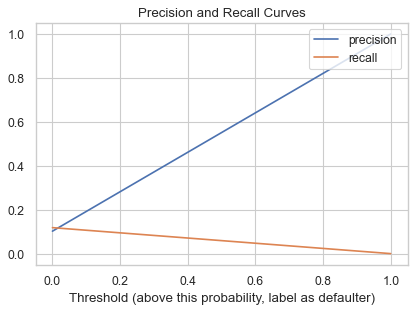

In [128]:
dt_full = DecisionTreeClassifier(max_depth = 150, criterion='entropy')
dt_full.fit(X_tr_rs, y_tr_rs)

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_te, dt_full.predict_proba(X_te)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='upper right')
plt.xlabel('Threshold (above this probability, label as defaulter)');
#plt.xlim([0,1]);
plt.title('Precision and Recall Curves');

In [129]:
#Decision Tree model with the selected params
#prediction on testing data
dt_full_pred = dt_full.predict(X_te)

y_predoss = (dt_full.predict_proba(X_te)[:,1]>0.01)
print('Logistic Regression on Oversampled Train Data; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_te, y_predoss), roc_auc_score(y_te, dt_full.predict_proba(X_te)[:,1])))

scoress = cross_val_score(dt_full, X_tr_rs, y_tr_rs, cv=10, scoring='accuracy')
print(scoress)
print('mean accuracy:',scoress.mean())

Logistic Regression on Oversampled Train Data; Test F1: 0.110, Test AUC: 0.508
[0.91991342 0.92207792 0.92694805 0.9258658  0.92855854 0.93559444
 0.92928017 0.92639365 0.92946058 0.9253112 ]
mean accuracy: 0.9269403787624967


Text(89.00000000000007, 0.5, 'actual')

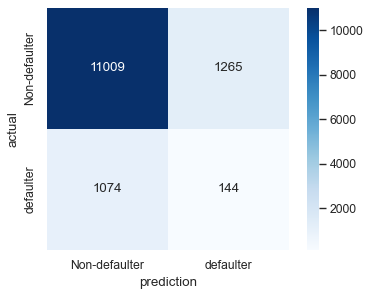

In [148]:
y_predict_g = (dt_full.predict_proba(X_te)[:, 1] >= 0.01)
fraud_confusion = confusion_matrix(y_te, y_predict_g)
plt.figure(dpi=80)
sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
       xticklabels=['Non-defaulter', 'defaulter'],
       yticklabels=['Non-defaulter', 'defaulter']);
plt.xlabel('prediction')
plt.ylabel('actual')

In [149]:
fraud_confusion

array([[11009,  1265],
       [ 1074,   144]])

### SMT

In [131]:
tree_param = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}

dt_s = DecisionTreeClassifier()
dt_grid_s = GridSearchCV(dt, tree_param, cv = 10)
# Fit the random search model
dt_grid_s.fit(X_tr_smt, y_tr_smt)

results = dt_grid_s.cv_results_

# View best parameter
print('Best Score: ', dt_grid_s.best_score_)
print('Best Param: ', dt_grid_s.best_params_)

Best Score:  0.8025434136993763
Best Param:  {'criterion': 'entropy', 'max_depth': 90}


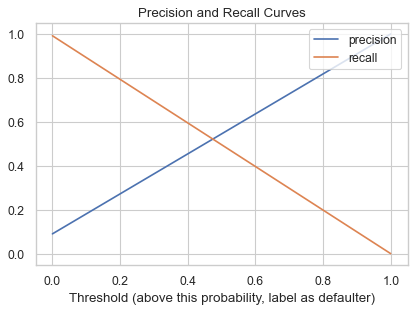

In [210]:
dt_full_st = DecisionTreeClassifier(max_depth = 90, criterion='entropy')
dt_full_st.fit(X_tr_smt, y_tr_smt)

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_te, dt_full_st.predict_proba(X_te)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='upper right')
plt.xlabel('Threshold (above this probability, label as defaulter)');
#plt.xlim([0,1]);
plt.title('Precision and Recall Curves');

In [350]:
#Decision Tree model with the selected params
#prediction on testing data
dt_full_pred_s = dt_full_st.predict(X_te)

y_predoss = (dt_full_st.predict_proba(X_te)[:,1]>0.5)
print('Logistic Regression on SMY Train Data; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_te, y_predoss), roc_auc_score(y_te, dt_full_st.predict_proba(X_te)[:,1])))
print('DS on SMT Train Data; PRECISION: %.3f, RECALL: %.3f' % \
      (precision_score(y_te, y_predoss), recall_score(y_te, y_predoss)))

Logistic Regression on SMY Train Data; Test F1: 0.165, Test AUC: 0.498
DS on SMT Train Data; PRECISION: 0.090, RECALL: 0.992


In [205]:
scoress = cross_val_score(dt_full_s, X_tr_smt, y_tr_smt, cv=10, scoring='accuracy')
print(scoress)
print('mean accuracy:',scoress.mean())

[0.69967532 0.67568543 0.81908369 0.82016595 0.82644777 0.83186
 0.83348367 0.8457514  0.8340249  0.82392206]
mean accuracy: 0.8010100196574127


Text(89.00000000000007, 0.5, 'actual')

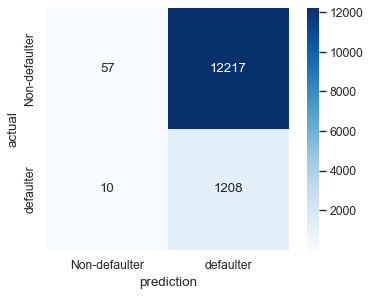

In [221]:
y_predict_gx = (dt_full_s.predict_proba(X_te)[:, 1] >= 0.5)
fraud_confusion = confusion_matrix(y_te, y_predict_gx)
plt.figure(dpi=80)
sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
       xticklabels=['Non-defaulter', 'defaulter'],
       yticklabels=['Non-defaulter', 'defaulter']);
plt.xlabel('prediction')
plt.ylabel('actual')


AttributeError: 'numpy.ndarray' object has no attribute 'info'

### Random Forest

In [159]:
ftwo_scorer = make_scorer(fbeta_score, beta=0.75, average='weighted')
accuracy_balanced = make_scorer(balanced_accuracy_score)
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 200, num = 3)]
# Number of features to consider at every split
max_features = ['auto']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num = 2)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1,5, 50]

# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

scoring = {"Fbeta": ftwo_scorer, "Balanced Accuracy": accuracy_balanced}
# First create the base model to tune
rf = RandomForestClassifier(class_weight='balanced')

rf_grid = GridSearchCV(estimator = rf, param_grid = param_grid, scoring = scoring,
                          cv = 3, n_jobs = -1, verbose = 2 , refit="Fbeta", return_train_score=True)
# Fit the random search model
rf_grid.fit(X_tr_rs, y_tr_rs)

results = rf_grid.cv_results_

# View best parameter
print('rsBest Score: ', rf_grid.best_score_)
print('rsBest Param: ', rf_grid.best_params_)

rf_grid.fit(X_tr_smt, y_tr_smt)

results = rf_grid.cv_results_

# View best parameter
print('smtBest Score: ', rf_grid.best_score_)
print('smtBest Param: ', rf_grid.best_params_)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
rsBest Score:  0.9957920629599712
rsBest Param:  {'max_depth': 50, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Fitting 3 folds for each of 54 candidates, totalling 162 fits
smtBest Score:  0.8885708818265171
smtBest Param:  {'max_depth': 50, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}


### rs

In [353]:
#Random Forest model with the selected params
rf_full = RandomForestClassifier(max_depth = 50, max_features= 'auto',min_samples_leaf = 1, 
                                       min_samples_split= 2, n_estimators=100)
rf_full.fit(X_tr_rs, y_tr_rs)

RandomForestClassifier(max_depth=50)

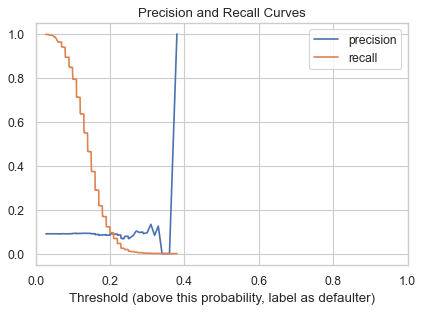

In [356]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_te, rf_full.predict_proba(X_te)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='upper right')
plt.xlabel('Threshold (above this probability, label as defaulter)');
plt.xlim([0,1]);
plt.title('Precision and Recall Curves');

In [357]:
scoress = cross_val_score(rf_full, X_tr_rs, y_tr_rs, cv=10, scoring='accuracy')
print(scoress)
print('mean accuracy:',scoress.mean())

[0.99296537 0.99314574 1.         1.         1.         1.
 1.         1.         1.         1.        ]
mean accuracy: 0.9986111111111111


In [354]:
thres = 0.2
y_predoss = (rf_full.predict_proba(X_te)[:,1]>thres)
print('Logistic Regression on Oversampled Train Data; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_te, y_predoss), roc_auc_score(y_te, rf_full.predict_proba(X_te)[:,1])))
print('DS on SMT Train Data; PRECISION: %.3f, RECALL: %.3f' % \
      (precision_score(y_te, y_predoss), recall_score(y_te, y_predoss)))

Logistic Regression on Oversampled Train Data; Test F1: 0.092, Test AUC: 0.503
DS on SMT Train Data; PRECISION: 0.089, RECALL: 0.095


Text(89.00000000000007, 0.5, 'actual')

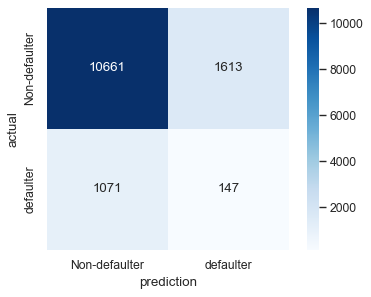

In [355]:
y_predict_g = (rf_full.predict_proba(X_te)[:, 1] >= thres)
fraud_confusion = confusion_matrix(y_te, y_predict_g)
plt.figure(dpi=80)
sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
       xticklabels=['Non-defaulter', 'defaulter'],
       yticklabels=['Non-defaulter', 'defaulter']);
plt.xlabel('prediction')
plt.ylabel('actual')

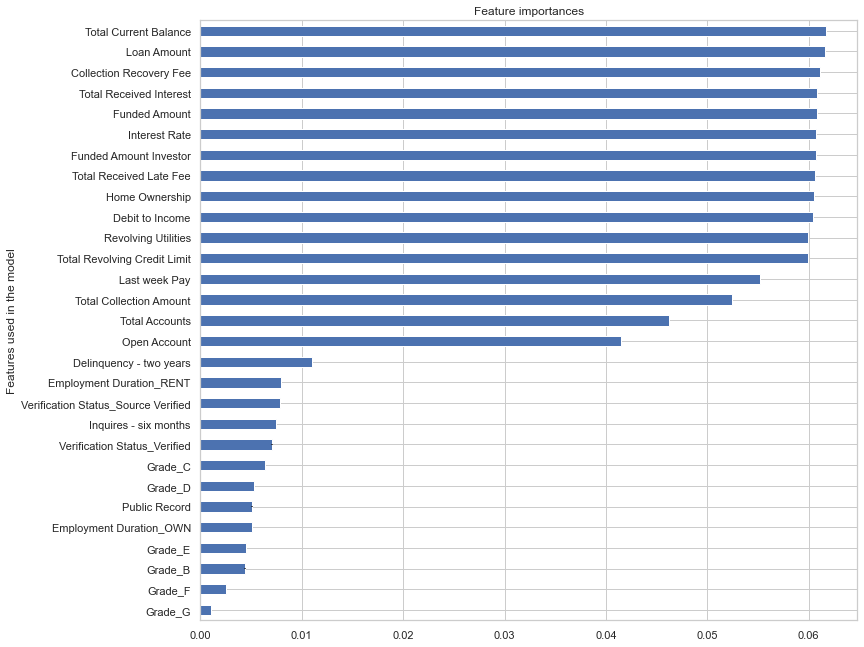

[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  22.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=150; total time=  15.8s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=200; total time=  21.8s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=50, min_samples_split=5, n_estimators=150; total time=  16.0s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  44.6s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=  38.4s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=50, min_samples_split=2, n_estimators=150; total time=  24.7s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=50, min_samples_split=5, n_estimators=150; total time=  24.7s
[CV] END max_depth=None, max_features

In [170]:
# compute feature importance and std
importances = rf_full.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_full.estimators_],
             axis=0)
indices = np.argsort(importances)

feature_list = [full_model[indices[f]] for f in range(X_te.shape[1])]  #names of features.
imp_list = [importances[indices[f]] for f in range(X_te.shape[1])]
ff = np.array(feature_list)

forest_importances = pd.Series(imp_list, index=feature_list)

fig, ax = plt.subplots()
forest_importances.plot.barh(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Features used in the model")
fig.tight_layout()
fig.set_size_inches(18.5, 10.5)
fig.savefig('feature_importance1.png', dpi=100)

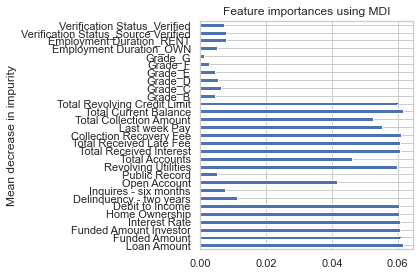

[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  11.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  21.8s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=150; total time=  16.8s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=50, min_samples_split=2, n_estimators=150; total time=  17.0s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  23.2s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=  33.0s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=  40.9s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=50, min_samples_split=2, n_estimators=150; total time=  21.7s
[CV] END max_depth=50, max_features=au

In [171]:
forest_importances2 = pd.Series(importances, index=full_model)

fig, ax = plt.subplots()
forest_importances2.plot.barh(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


In [172]:
importance_df_xgb = pd.DataFrame(importances, index=full_model, 
                      columns=["Importance"])
importance_df_xgb.sort_values(by= 'Importance', ascending=False)

Importance
Total Current Balance                  0.061673
Loan Amount                            0.061616
Collection Recovery Fee                0.061067
Total Received Interest                0.060831
Funded Amount                          0.060799
Interest Rate                          0.060760
Funded Amount Investor                 0.060731
Total Received Late Fee                0.060662
Home Ownership                         0.060537
Debit to Income                        0.060460
Revolving Utilities                    0.059947
Total Revolving Credit Limit           0.059921
Last week Pay                          0.055227
Total Collection Amount                0.052404
Total Accounts                         0.046225
Open Account                           0.041520
Delinquency - two years                0.011010
Employment Duration_RENT               0.007931
Verification Status_Source Verified    0.007848
Inquires - six months                  0.007476
Verification Status_Verified           0.007053
Grade_C                                0.006367
Grade_D                                0.005266
Public Record                          0.005073
Employment Duration_OWN                0.005053
Grade_E                                0.004531
Grade_B                                0.004393
Grade_F                                0.002519
Grade_G                                0.001099

[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  10.6s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=  16.9s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=  22.6s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=50, min_samples_split=2, n_estimators=200; total time=  22.0s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=  36.1s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=  20.2s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=  22.2s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=50, min_samples_split=2, n_estimators=100; total time=  17.1s
[CV] END max_depth=50, max_features=au

### SMT

In [358]:
#Random Forest model with the selected params
rf_full = RandomForestClassifier(max_depth = 50, max_features= 'auto',min_samples_leaf = 1, 
                                       min_samples_split= 2, n_estimators=150)
rf_full.fit(X_tr_smt, y_tr_smt)

RandomForestClassifier(max_depth=50, n_estimators=150)

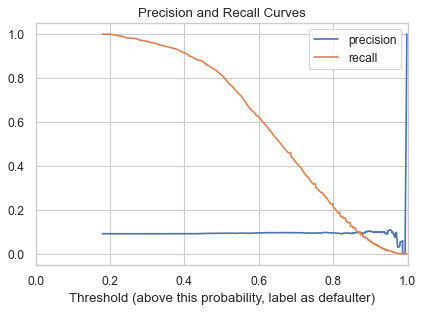

In [359]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_te, rf_full.predict_proba(X_te)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='upper right')
plt.xlabel('Threshold (above this probability, label as defaulter)');
plt.xlim([0,1]);
plt.title('Precision and Recall Curves');

In [175]:
scoress = cross_val_score(rf_full, X_tr_smt, y_tr_smt, cv=10, scoring='accuracy')
print(scoress)
print('mean accuracy:',scoress.mean())

[0.77362915 0.76677489 0.94498557 0.95238095 0.94335198 0.9485838
 0.95580011 0.94930543 0.95056828 0.94605809]
mean accuracy: 0.9131438251747651


In [192]:
thres = 0.86
y_predoss = (rf_full.predict_proba(X_te)[:,1]>thres)
print('Logistic Regression on Oversampled Train Data; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_te, y_predoss), roc_auc_score(y_te, rf_full.predict_proba(X_te)[:,1])))

Logistic Regression on Oversampled Train Data; Test F1: 0.109, Test AUC: 0.513


Text(89.00000000000007, 0.5, 'actual')

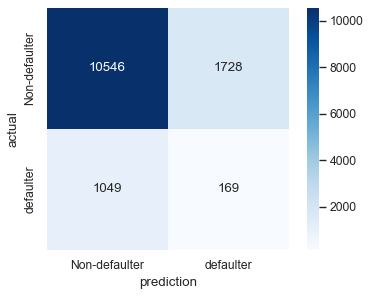

In [193]:
y_predict_g = (rf_full.predict_proba(X_te)[:, 1] >= thres)
fraud_confusion = confusion_matrix(y_te, y_predict_g)
plt.figure(dpi=80)
sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
       xticklabels=['Non-defaulter', 'defaulter'],
       yticklabels=['Non-defaulter', 'defaulter']);
plt.xlabel('prediction')
plt.ylabel('actual')

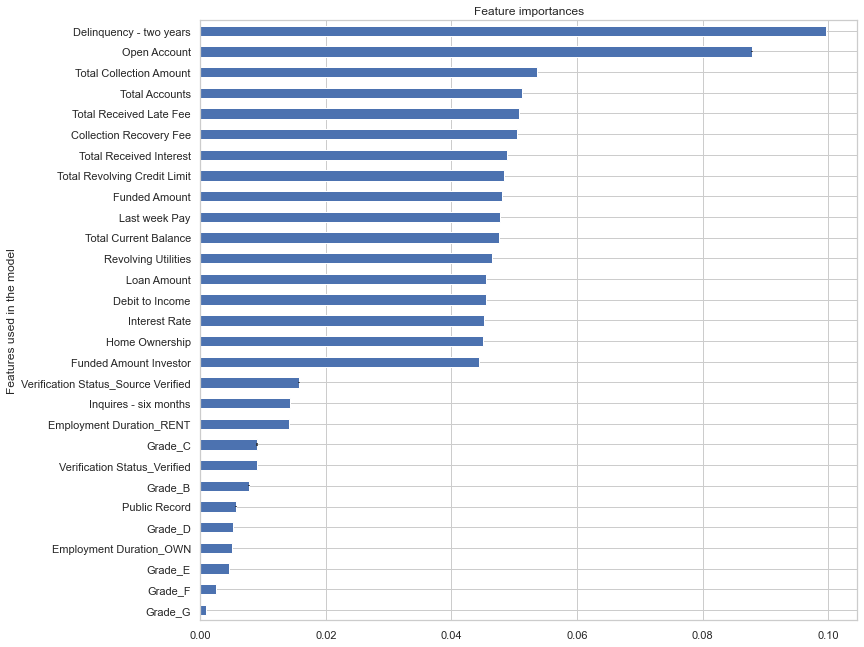

In [360]:
# compute feature importance and std
importances = rf_full.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_full.estimators_],
             axis=0)
indices = np.argsort(importances)

feature_list = [full_model[indices[f]] for f in range(X_te.shape[1])]  #names of features.
imp_list = [importances[indices[f]] for f in range(X_te.shape[1])]
ff = np.array(feature_list)

forest_importances = pd.Series(imp_list, index=feature_list)

fig, ax = plt.subplots()
forest_importances.plot.barh(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Features used in the model")
fig.tight_layout()
fig.set_size_inches(18.5, 10.5)
fig.savefig('feature_importance1.png', dpi=100)

### Gradient Boosted Trees xgboost

In [96]:
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.utils import class_weight
from xgboost.sklearn import XGBClassifier

In [97]:
xgb_model = xgb.XGBClassifier(n_estimators=1000, learning_rate=0.1, 
                          max_depth=4, subsample=0.8,  min_child_weight = 1)
eval_set=[(X_tr_rs,y_tr_rs),(X_te,y_te)] #tracking train/validation error as we go
xgb_fit = xgb_model.fit( 
                        X_tr_rs, y_tr_rs, 
                        early_stopping_rounds = 50,eval_metric = 'rmse',
                        eval_set = eval_set,verbose = True)

xgb_preds = xgb_model.predict(X_te, ntree_limit=xgb_model.best_ntree_limit)
    
# compute metric of interest
xgb_fbeta = fbeta_score(y_te, xgb_preds, beta=0.75, average='weighted') 
xgb_accuracy =  balanced_accuracy_score(y_te,  xgb_preds)

print('XGBoost | Full Fbeta score:  %.3f  \t' % xgb_fbeta)
print('XGBoost | Full Balanced Accuracy score:  %.3f  \t' % xgb_accuracy)

/home/yingqing/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-rmse:0.49440	validation_1-rmse:0.48691
[1]	validation_0-rmse:0.48973	validation_1-rmse:0.47516
[2]	validation_0-rmse:0.48597	validation_1-rmse:0.46485
[3]	validation_0-rmse:0.48280	validation_1-rmse:0.45578
[4]	validation_0-rmse:0.48016	validation_1-rmse:0.44717
[5]	validation_0-rmse:0.47795	validation_1-rmse:0.43998
[6]	validation_0-rmse:0.47613	validation_1-rmse:0.43334
[7]	validation_0-rmse:0.47450	validation_1-rmse:0.42747
[8]	validation_0-rmse:0.47313	validation_1-rmse:0.42237
[9]	validation_0-rmse:0.47200	validation_1-rmse:0.41780
[10]	validation_0-rmse:0.47104	validation_1-rmse:0.41357
[11]	validation_0-rmse:0.47014	validation_1-rmse:0.40990
[12]	validation_0-rmse:0.46935	validation_1-rmse:0.40678
[13]	validation_0-rmse:0.46860	validation_1-rmse:0.40394
[14]	validation_0-rmse:0.46804	validation_1-rmse:0.40122
[15]	validation_0-rmse:0.46754	validation_1-rmse:0.39865
[16]	validation_0-rmse:0.46710	validation_1-rmse:0.39619
[17]	validation_0-rmse:0.46671	validation

[144]	validation_0-rmse:0.43604	validation_1-rmse:0.36931
[145]	validation_0-rmse:0.43577	validation_1-rmse:0.36933
[146]	validation_0-rmse:0.43550	validation_1-rmse:0.36919
[147]	validation_0-rmse:0.43540	validation_1-rmse:0.36919
[148]	validation_0-rmse:0.43522	validation_1-rmse:0.36923
[149]	validation_0-rmse:0.43509	validation_1-rmse:0.36924
[150]	validation_0-rmse:0.43479	validation_1-rmse:0.36909
[151]	validation_0-rmse:0.43454	validation_1-rmse:0.36895
[152]	validation_0-rmse:0.43445	validation_1-rmse:0.36887
[153]	validation_0-rmse:0.43439	validation_1-rmse:0.36881
[154]	validation_0-rmse:0.43408	validation_1-rmse:0.36864
[155]	validation_0-rmse:0.43404	validation_1-rmse:0.36865
[156]	validation_0-rmse:0.43379	validation_1-rmse:0.36870
[157]	validation_0-rmse:0.43352	validation_1-rmse:0.36861
[158]	validation_0-rmse:0.43341	validation_1-rmse:0.36862
[159]	validation_0-rmse:0.43324	validation_1-rmse:0.36856
[160]	validation_0-rmse:0.43302	validation_1-rmse:0.36850
[161]	validati

[286]	validation_0-rmse:0.40882	validation_1-rmse:0.36182
[287]	validation_0-rmse:0.40864	validation_1-rmse:0.36185
[288]	validation_0-rmse:0.40841	validation_1-rmse:0.36176
[289]	validation_0-rmse:0.40837	validation_1-rmse:0.36166
[290]	validation_0-rmse:0.40810	validation_1-rmse:0.36160
[291]	validation_0-rmse:0.40782	validation_1-rmse:0.36150
[292]	validation_0-rmse:0.40765	validation_1-rmse:0.36151
[293]	validation_0-rmse:0.40757	validation_1-rmse:0.36146
[294]	validation_0-rmse:0.40726	validation_1-rmse:0.36132
[295]	validation_0-rmse:0.40710	validation_1-rmse:0.36132
[296]	validation_0-rmse:0.40678	validation_1-rmse:0.36127
[297]	validation_0-rmse:0.40672	validation_1-rmse:0.36134
[298]	validation_0-rmse:0.40659	validation_1-rmse:0.36131
[299]	validation_0-rmse:0.40634	validation_1-rmse:0.36118
[300]	validation_0-rmse:0.40607	validation_1-rmse:0.36112
[301]	validation_0-rmse:0.40592	validation_1-rmse:0.36116
[302]	validation_0-rmse:0.40573	validation_1-rmse:0.36096
[303]	validati

[428]	validation_0-rmse:0.38532	validation_1-rmse:0.35562
[429]	validation_0-rmse:0.38528	validation_1-rmse:0.35562
[430]	validation_0-rmse:0.38509	validation_1-rmse:0.35567
[431]	validation_0-rmse:0.38494	validation_1-rmse:0.35555
[432]	validation_0-rmse:0.38490	validation_1-rmse:0.35553
[433]	validation_0-rmse:0.38465	validation_1-rmse:0.35552
[434]	validation_0-rmse:0.38459	validation_1-rmse:0.35548
[435]	validation_0-rmse:0.38440	validation_1-rmse:0.35553
[436]	validation_0-rmse:0.38417	validation_1-rmse:0.35540
[437]	validation_0-rmse:0.38412	validation_1-rmse:0.35543
[438]	validation_0-rmse:0.38391	validation_1-rmse:0.35541
[439]	validation_0-rmse:0.38378	validation_1-rmse:0.35537
[440]	validation_0-rmse:0.38366	validation_1-rmse:0.35530
[441]	validation_0-rmse:0.38345	validation_1-rmse:0.35521
[442]	validation_0-rmse:0.38336	validation_1-rmse:0.35519
[443]	validation_0-rmse:0.38309	validation_1-rmse:0.35523
[444]	validation_0-rmse:0.38298	validation_1-rmse:0.35516
[445]	validati

[570]	validation_0-rmse:0.36260	validation_1-rmse:0.34929
[571]	validation_0-rmse:0.36247	validation_1-rmse:0.34928
[572]	validation_0-rmse:0.36218	validation_1-rmse:0.34913
[573]	validation_0-rmse:0.36197	validation_1-rmse:0.34913
[574]	validation_0-rmse:0.36184	validation_1-rmse:0.34902
[575]	validation_0-rmse:0.36179	validation_1-rmse:0.34902
[576]	validation_0-rmse:0.36171	validation_1-rmse:0.34899
[577]	validation_0-rmse:0.36168	validation_1-rmse:0.34901
[578]	validation_0-rmse:0.36143	validation_1-rmse:0.34896
[579]	validation_0-rmse:0.36129	validation_1-rmse:0.34895
[580]	validation_0-rmse:0.36113	validation_1-rmse:0.34891
[581]	validation_0-rmse:0.36102	validation_1-rmse:0.34892
[582]	validation_0-rmse:0.36084	validation_1-rmse:0.34886
[583]	validation_0-rmse:0.36074	validation_1-rmse:0.34888
[584]	validation_0-rmse:0.36059	validation_1-rmse:0.34886
[585]	validation_0-rmse:0.36040	validation_1-rmse:0.34888
[586]	validation_0-rmse:0.36027	validation_1-rmse:0.34886
[587]	validati

[712]	validation_0-rmse:0.34309	validation_1-rmse:0.34449
[713]	validation_0-rmse:0.34293	validation_1-rmse:0.34445
[714]	validation_0-rmse:0.34281	validation_1-rmse:0.34436
[715]	validation_0-rmse:0.34263	validation_1-rmse:0.34438
[716]	validation_0-rmse:0.34238	validation_1-rmse:0.34444
[717]	validation_0-rmse:0.34226	validation_1-rmse:0.34436
[718]	validation_0-rmse:0.34215	validation_1-rmse:0.34432
[719]	validation_0-rmse:0.34209	validation_1-rmse:0.34439
[720]	validation_0-rmse:0.34190	validation_1-rmse:0.34438
[721]	validation_0-rmse:0.34180	validation_1-rmse:0.34431
[722]	validation_0-rmse:0.34157	validation_1-rmse:0.34434
[723]	validation_0-rmse:0.34143	validation_1-rmse:0.34422
[724]	validation_0-rmse:0.34121	validation_1-rmse:0.34422
[725]	validation_0-rmse:0.34105	validation_1-rmse:0.34412
[726]	validation_0-rmse:0.34095	validation_1-rmse:0.34401
[727]	validation_0-rmse:0.34077	validation_1-rmse:0.34398
[728]	validation_0-rmse:0.34061	validation_1-rmse:0.34400
[729]	validati

[854]	validation_0-rmse:0.32463	validation_1-rmse:0.34066
[855]	validation_0-rmse:0.32455	validation_1-rmse:0.34055
[856]	validation_0-rmse:0.32444	validation_1-rmse:0.34056
[857]	validation_0-rmse:0.32429	validation_1-rmse:0.34051
[858]	validation_0-rmse:0.32424	validation_1-rmse:0.34040
[859]	validation_0-rmse:0.32409	validation_1-rmse:0.34041
[860]	validation_0-rmse:0.32397	validation_1-rmse:0.34030
[861]	validation_0-rmse:0.32389	validation_1-rmse:0.34026
[862]	validation_0-rmse:0.32381	validation_1-rmse:0.34026
[863]	validation_0-rmse:0.32373	validation_1-rmse:0.34028
[864]	validation_0-rmse:0.32366	validation_1-rmse:0.34029
[865]	validation_0-rmse:0.32353	validation_1-rmse:0.34027
[866]	validation_0-rmse:0.32345	validation_1-rmse:0.34027
[867]	validation_0-rmse:0.32333	validation_1-rmse:0.34022
[868]	validation_0-rmse:0.32316	validation_1-rmse:0.34024
[869]	validation_0-rmse:0.32299	validation_1-rmse:0.34028
[870]	validation_0-rmse:0.32301	validation_1-rmse:0.34019
[871]	validati

[996]	validation_0-rmse:0.30781	validation_1-rmse:0.33706
[997]	validation_0-rmse:0.30773	validation_1-rmse:0.33710
[998]	validation_0-rmse:0.30757	validation_1-rmse:0.33708
[999]	validation_0-rmse:0.30749	validation_1-rmse:0.33704
XGBoost | Full Fbeta score:  0.854  	
XGBoost | Full Balanced Accuracy score:  0.501  	


/home/yingqing/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/yingqing/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


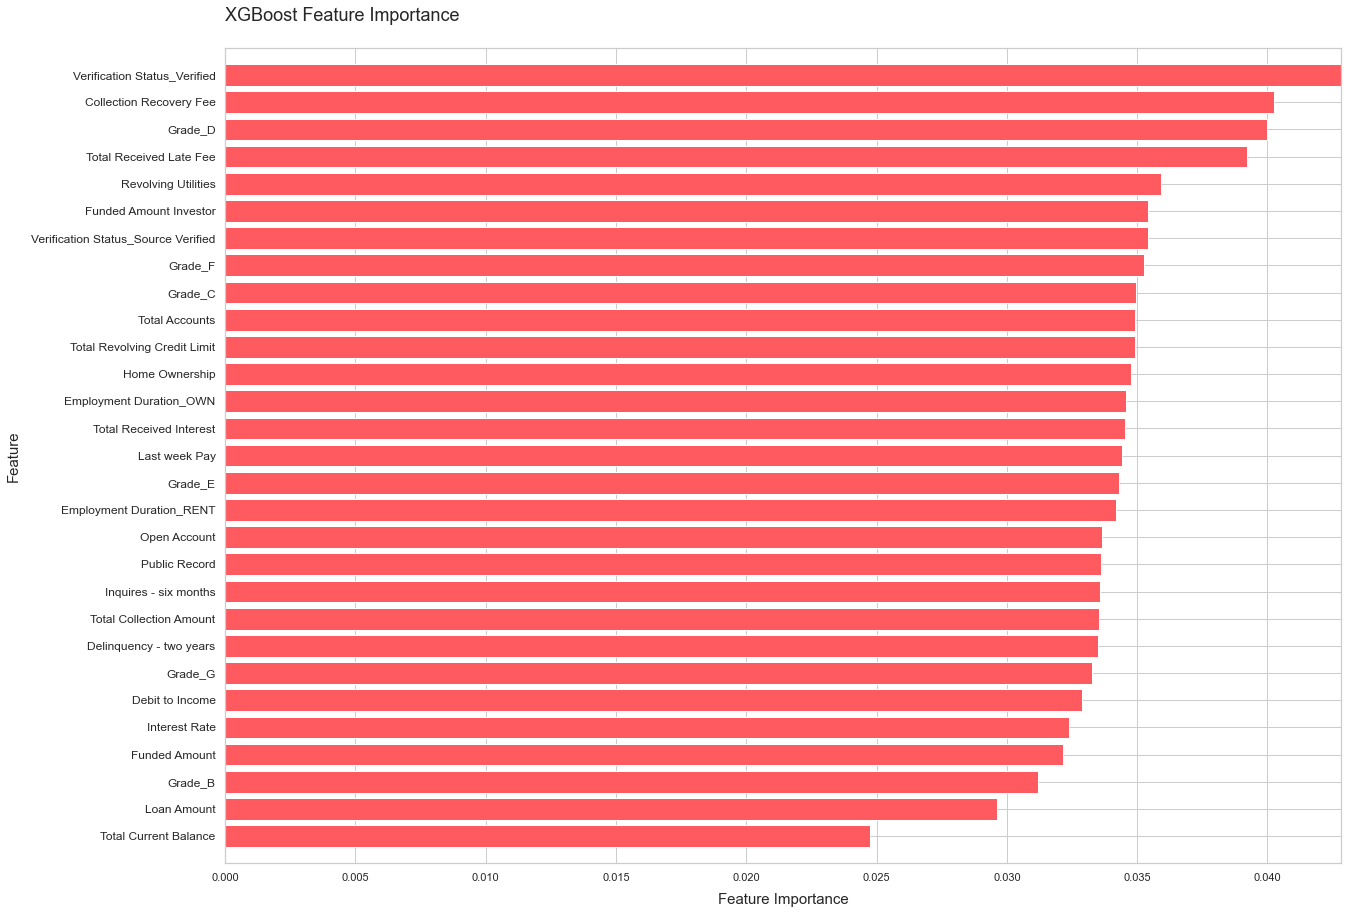

In [248]:
importances_xgb = xgb_model.feature_importances_

indices = np.argsort(importances_xgb)

feature_list = [full_model[indices[f]] for f in range(X_te.shape[1])]  #names of features.
ff = np.array(feature_list)

# plot the feature importances of the random forest
plt.figure(figsize=(20,15))
plt.margins(x=0)
sns.set_style("whitegrid")
plt.title("XGBoost Feature Importance\n",fontsize = 18,loc = 'left')
ax = plt.barh(range(X_te.shape[1]), importances_xgb[indices],
       color = '#FF5A5F',ecolor ='#484848', align="center")

# set labels
plt.xlabel('Feature Importance',labelpad = 10,fontsize = 15)
plt.ylabel('Feature',labelpad = 10,fontsize = 15)
plt.yticks(range(X_te.shape[1]), ff[indices],fontsize = 12)
plt.ylim([-1, X_te.shape[1]])
#plt.savefig('xgboost_feature.png',dpi =150)

plt.show()

In [251]:
xgb_model.get_booster().get_score(importance_type='gain')

{'Total Collection Amount': 11.650214922795485,
 'Open Account': 11.764696189319785,
 'Total Accounts': 11.72327594395936,
 'Total Current Balance': 12.238863444553749,
 'Grade_B': 13.706467669084784,
 'Total Received Late Fee': 12.014572915746173,
 'Home Ownership': 11.447052176474626,
 'Loan Amount': 11.329029850756964,
 'Grade_D': 13.355110856315788,
 'Revolving Utilities': 11.84656961495647,
 'Debit to Income': 11.8882511528444,
 'Collection Recovery Fee': 11.897444757808053,
 'Funded Amount Investor': 12.062478423198845,
 'Total Revolving Credit Limit': 11.208234934456568,
 'Interest Rate': 11.43544488647115,
 'Total Received Interest': 11.417684366374441,
 'Funded Amount': 11.412070495983977,
 'Last week Pay': 11.469170428953344,
 'Employment Duration_RENT': 11.772945130962267,
 'Delinquency - two years': 10.091179693529412,
 'Inquires - six months': 10.956427835729171,
 'Public Record': 11.03746824818182,
 'Employment Duration_OWN': 13.620375251764706,
 'Grade_C': 14.58854781863

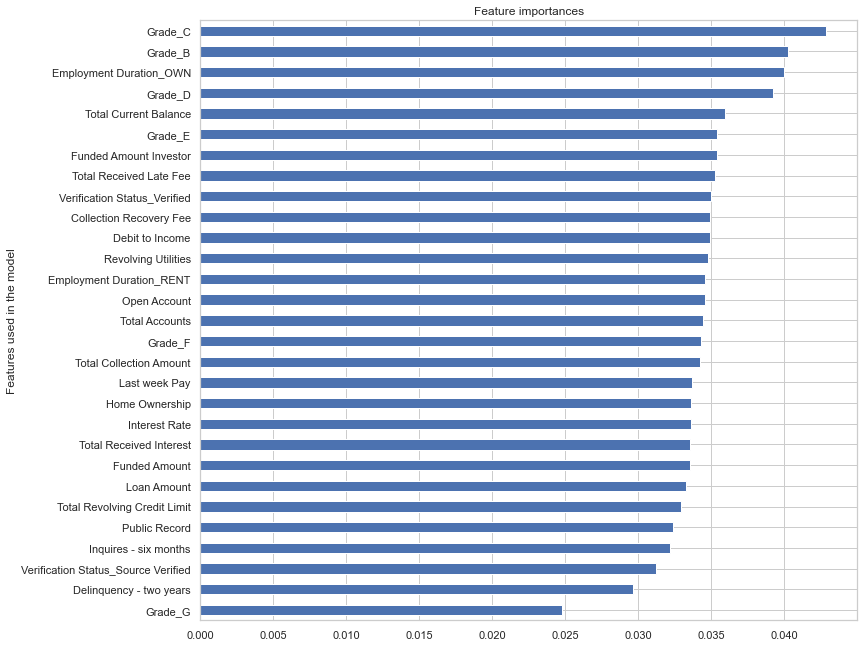

In [247]:
# compute feature importance and std
#importances_xgb = xgb_model.feature_importances_

#indices = np.argsort(importances_xgb)

#feature_list = [full_model[indices[f]] for f in range(X_te.shape[1])]  #names of features.
#ff = np.array(feature_list)

# plot the feature importances of the random forest
#plt.figure(figsize=(20,15))
#plt.margins(x=0)
#sns.set_style("whitegrid")
#plt.title("XGBoost Feature Importance\n",fontsize = 18,loc = 'left')
#ax = plt.barh(range(X_te.shape[1]), importances_xgb[indices],
#       color = '#FF5A5F',ecolor ='#484848', align="center")

# set labels
#plt.xlabel('Feature Importance',labelpad = 10,fontsize = 15)
#plt.ylabel('Feature',labelpad = 10,fontsize = 15)
#plt.yticks(range(X_te.shape[1]), ff[indices],fontsize = 12)
#plt.ylim([-1, X_te.shape[1]])
#plt.savefig('xgboost_feature.png',dpi =150)

#plt.show()

importances = xgb_model.feature_importances_
#std = np.std([tree.feature_importances_ for tree in xgb_model.estimators_],
#             axis=0)
indices = np.argsort(importances)

feature_list = [full_model[indices[f]] for f in range(X_te.shape[1])]  #names of features.
imp_list = [importances[indices[f]] for f in range(X_te.shape[1])]
ff = np.array(feature_list)

forest_importances = pd.Series(imp_list, index=feature_list)

fig, ax = plt.subplots()
forest_importances.plot.barh( ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Features used in the model")
fig.tight_layout()
fig.set_size_inches(18.5, 10.5)
fig.savefig('feature_importance1.png', dpi=100)


In [158]:
def rmse(actuals, preds):
    return np.sqrt(((actuals - preds) ** 2).mean())
rmse(gbm.predict(X_te, ntree_limit=gbm.best_ntree_limit),y_te) 
rmse(gbm.predict(X_val, ntree_limit=gbm.best_ntree_limit),y_val) 

/home/yingqing/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/yingqing/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


0.29373615808282383

/home/yingqing/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/tmp/ipykernel_3902/3593266459.py:6: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(threshold_curve, 2*(recall_curve[1:]*precision_curve[1:])/(precision_curve[1:]+recall_curve[1:]), label='f1')


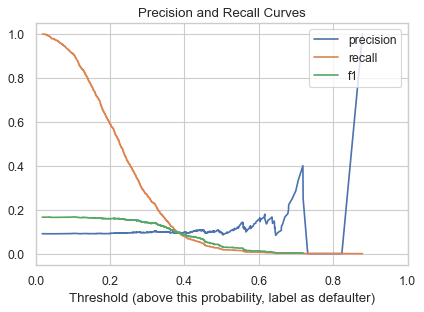

In [245]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_te, xgb_model.predict_proba(X_te)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.plot(threshold_curve, 2*(recall_curve[1:]*precision_curve[1:])/(precision_curve[1:]+recall_curve[1:]), label='f1')
plt.legend(loc='upper right')
plt.xlabel('Threshold (above this probability, label as defaulter)');
plt.xlim([0,1]);
plt.title('Precision and Recall Curves');

In [104]:
scoress = cross_val_score(xgb_model, X_tr_rs, y_tr_rs, cv=10, scoring='accuracy')
print(scoress)
print('mean accuracy:',scoress.mean())

/home/yingqing/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:39:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/yingqing/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/yingqing/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:48:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/yingqing/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/yingqing/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:57:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/yingqing/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/yingqing/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:06:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/yingqing/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/yingqing/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:15:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/yingqing/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/yingqing/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:24:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/yingqing/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/yingqing/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:32:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/yingqing/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/yingqing/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:42:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/yingqing/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/yingqing/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:50:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/yingqing/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/yingqing/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:59:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0.85407648 0.8488456  0.87157287 0.87896825 0.87533826 0.87714234
 0.87551867 0.87227133 0.87642071 0.88111131]
mean accuracy: 0.8711265837415937


/home/yingqing/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


/home/yingqing/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


Text(89.00000000000007, 0.5, 'actual')

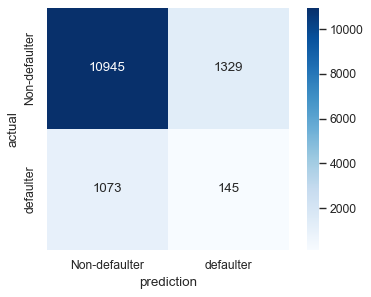

In [257]:
thres = 0.37
y_predict_g = (xgb_model.predict_proba(X_te)[:, 1] >= thres)
fraud_confusion = confusion_matrix(y_te, y_predict_g)
plt.figure(dpi=80)
sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
       xticklabels=['Non-defaulter', 'defaulter'],
       yticklabels=['Non-defaulter', 'defaulter']);
plt.xlabel('prediction')
plt.ylabel('actual')

In [256]:
y_predoss = (xgb_model.predict_proba(X_te)[:,1]>0.37)
print('XGB on Oversampled Train Data; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_te, y_predoss), roc_auc_score(y_te, xgb_model.predict_proba(X_te)[:,1])))

XGB on Oversampled Train Data; Test F1: 0.108, Test AUC: 0.513


/home/yingqing/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/yingqing/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [103]:
recall_v = recall_score(y_te, xgb_model.predict(X_te))
recall_v
precision_v = precision_score(y_te, xgb_model.predict(X_te))
print(recall_v, precision_v)
recall_vp = recall_score(y_te, xgb_model.predict_proba(X_te)[:,1] > thres)
recall_vp
precision_vp = precision_score(y_te, xgb_model.predict_proba(X_te)[:,1]>thres)
print(recall_vp, precision_vp)

/home/yingqing/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/yingqing/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/yingqing/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/yingqing/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


0.020525451559934318 0.09578544061302682
0.08784893267651889 0.09361329833770779


In [258]:
#xgb_model.plot_importance(gbm)
#xgb_model.plot_importance(gbm, importance_type='gain')

In [259]:
#gbm.get_booster().get_score(importance_type='weight') #extract raw frequency scores
#gbm.get_booster().get_score(importance_type='gain') #extract raw gain scores

### smt

In [338]:
xgb_model2 = xgb.XGBClassifier(n_estimators=1000, learning_rate=1, 
                          max_depth=3, subsample=0.8,  min_child_weight = 1)
eval_set=[(X_tr_smt,y_tr_smt),(X_te,y_te)] #tracking train/validation error as we go
xgb_model2.fit( 
                        X_tr_smt, y_tr_smt, 
                        early_stopping_rounds = 50,eval_metric = 'rmse',
                        eval_set = eval_set,verbose = False)

xgb_preds2 = xgb_model2.predict(X_te, ntree_limit=xgb_model2.best_ntree_limit)
    
# compute metric of interest
xgb_fbeta = fbeta_score(y_te, xgb_preds2, beta=0.75, average='weighted') 
xgb_accuracy =  balanced_accuracy_score(y_te,  xgb_preds2)

print('XGBoost | Full Fbeta score:  %.3f  \t' % xgb_fbeta)
print('XGBoost | Full Balanced Accuracy score:  %.3f  \t' % xgb_accuracy)

/home/yingqing/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBoost | Full Fbeta score:  0.136  	
XGBoost | Full Balanced Accuracy score:  0.499  	


/home/yingqing/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/yingqing/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


/home/yingqing/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/tmp/ipykernel_3902/2949125389.py:6: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(threshold_curve, 2*(recall_curve[1:]*precision_curve[1:])/(precision_curve[1:]+recall_curve[1:]), label='f1')


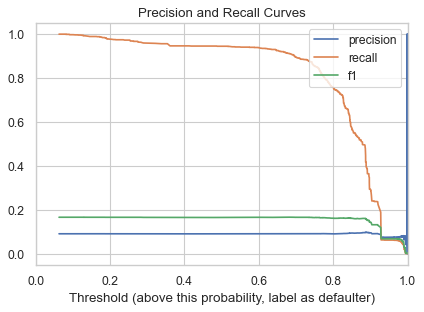

In [339]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_te, xgb_model2.predict_proba(X_te)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.plot(threshold_curve, 2*(recall_curve[1:]*precision_curve[1:])/(precision_curve[1:]+recall_curve[1:]), label='f1')
plt.legend(loc='upper right')
plt.xlabel('Threshold (above this probability, label as defaulter)');
plt.xlim([0,1]);
plt.title('Precision and Recall Curves');

/home/yingqing/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


Text(89.00000000000007, 0.5, 'actual')

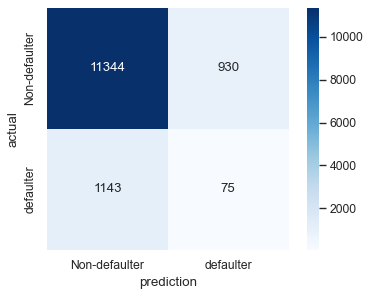

In [340]:
thres = 0.95
y_predict_g = (xgb_model2.predict_proba(X_te)[:, 1] >= thres)
fraud_confusion = confusion_matrix(y_te, y_predict_g)
plt.figure(dpi=80)
sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
       xticklabels=['Non-defaulter', 'defaulter'],
       yticklabels=['Non-defaulter', 'defaulter']);
plt.xlabel('prediction')
plt.ylabel('actual')

In [344]:
y_predoss = (xgb_model2.predict_proba(X_te)[:,1]>0.95)
print('XGB on SMT Train Data; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_te, y_predoss), roc_auc_score(y_te, xgb_model2.predict_proba(X_te)[:,1])))
print('XGB on SMT Train Data; PRECISION: %.3f, RECALL: %.3f' % \
      (precision_score(y_te, y_predoss), recall_score(y_te, y_predoss)))

XGB on SMT Train Data; Test F1: 0.067, Test AUC: 0.509
XGB on SMT Train Data; PRECISION: 0.075, RECALL: 0.062


/home/yingqing/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/yingqing/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [346]:
scoress = cross_val_score(xgb_model2, X_tr_smt, y_tr_smt, cv=10, scoring='accuracy')
print(scoress)
print('mean accuracy:',scoress.mean())

/home/yingqing/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:24:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/yingqing/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/yingqing/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:27:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/yingqing/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/yingqing/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:30:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/yingqing/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/yingqing/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:32:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/yingqing/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/yingqing/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:35:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/yingqing/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/yingqing/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:37:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/yingqing/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/yingqing/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:40:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/yingqing/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/yingqing/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:42:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/yingqing/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/yingqing/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:44:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/yingqing/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/yingqing/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:47:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0.65620491 0.66107504 0.95995671 0.95743146 0.96175356 0.95399603
 0.95273318 0.95652174 0.95543929 0.95616092]
mean accuracy: 0.8971272836350412


/home/yingqing/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
